# Proof of concept notebook for the Frame Booster project
- Author: Kamil Barszczak
- Contact: kamilbarszczak62@gmail.com
- Project: https://github.com/kbarszczak/Frame_booster

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os

import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchsummary
import torchvision
import torch

#### Notebook parameters

In [2]:
base_path = 'E:/Data/Video_Frame_Interpolation/processed/vimeo90k_pytorch'
data_subdir = 'data'
vis_subdir = 'vis'
train_ids = 'train.txt'
test_ids = 'test.txt'
valid_ids = 'valid.txt'
vis_ids = 'vis.txt'

width, height = 256, 144
epochs = 4
batch = 2

#### Setup device

In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


#### Load datasets

In [4]:
class ByteImageDataset(data.Dataset):
    def __init__(self, path, subdir, split_filename, shape):
        self.path = path
        self.subdir = subdir
        self.shape = shape
        self.ids = pd.read_csv(os.path.join(path, split_filename), names=["ids"])
        
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.subdir, str(self.ids.iloc[idx, 0]))
        
        imgs = [
            self._read_bytes_to_tensor(os.path.join(img_path, 'im1')),
            self._read_bytes_to_tensor(os.path.join(img_path, 'im3'))
        ]
        true = self._read_bytes_to_tensor(os.path.join(img_path, 'im2'))
        
        return imgs, true
    
    def _read_bytes_to_tensor(self, path):
        with open(path, 'rb') as bf:
            buf = bf.read()
            if len(buf) <= 0:
                print(F"Wrong buffer for {path}")
            return torch.permute(torch.reshape(torch.frombuffer(buf, dtype=torch.float), self.shape), (2, 0, 1))

In [5]:
train_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = data_subdir,
        split_filename = train_ids,
        shape = (height, width, 3)
    ),
    shuffle = True,
    batch_size = batch,
    drop_last = True
)

test_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = data_subdir,
        split_filename = test_ids,
        shape = (height, width, 3)
    ),
    batch_size = batch,
    drop_last = True
)

valid_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = data_subdir,
        split_filename = valid_ids,
        shape = (height, width, 3)
    ),
    batch_size = batch,
    drop_last = True
)

vis_dataloader = data.DataLoader(
    dataset = ByteImageDataset(
        path = base_path,
        subdir = vis_subdir,
        split_filename = vis_ids,
        shape = (height, width, 3)
    ),
    batch_size = 1,
    drop_last = True,
    shuffle = False
)

In [6]:
print(f'Training batches: {len(train_dataloader)}')
print(f'Testing batches: {len(test_dataloader)}')
print(f'Validating batches: {len(valid_dataloader)}')
print(f'Visualizing batches: {len(vis_dataloader)}')

Training batches: 25000
Testing batches: 1500
Validating batches: 500
Visualizing batches: 1021


#### Create the model

In [7]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        self.__name__ = "perceptual"
        blocks = []
        blocks.append(torchvision.models.vgg16(weights='DEFAULT').features[:4].eval().to(device))
        blocks.append(torchvision.models.vgg16(weights='DEFAULT').features[4:9].eval().to(device))
        blocks.append(torchvision.models.vgg16(weights='DEFAULT').features[9:16].eval().to(device))
        blocks.append(torchvision.models.vgg16(weights='DEFAULT').features[16:23].eval().to(device))
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = nn.ModuleList(blocks).to(device)
        self.transform = F.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += F.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

    
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))


def mse(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)


def psnr(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    psnr = 20 * torch.log10(1 / torch.sqrt(mse))
    return 1 - psnr / 40.0


perceptual_loss = VGGPerceptualLoss()
    
    
def loss(y_true, y_pred):
    perceptual_loss_ = perceptual_loss(y_true, y_pred)
    psnr_ = psnr(y_true, y_pred)
    mse_ = mse(y_true, y_pred)
    mae_ = mae(y_true, y_pred)
    
    return perceptual_loss_ + psnr_ + 5.0*mae_ + 10.0*mse_

In [8]:
class FlowFeatureWarp(nn.Module):
    def __init__(self, flow_input_chanels, return_flow = True,
                flow_info = {
                    "filter_counts": [32, 32, 64, 64, 96, 96, 64, 32],
                    "filter_sizes": [(7, 7), (7, 7), (5, 5), (5, 5), (3, 3), (3, 3), (1, 1), (1, 1)],
                    "filter_strides": [1, 1, 1, 1, 1, 1, 1, 1],
                    "filter_paddings": [6, 3, 4, 2, 2, 1, 0, 0],
                    "filter_dilations": [2, 1, 2, 1, 2, 1, 1, 1],
                    "activations": [nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU()],
                }, interpolation='bilinear', **kwargs):
        super(FlowFeatureWarp, self).__init__(**kwargs)
        
        fcounts = flow_info['filter_counts']
        fsizes = flow_info['filter_sizes']
        fstrides = flow_info['filter_strides']
        fpads = flow_info['filter_paddings']
        fdils = flow_info['filter_dilations']
        facts = flow_info['activations']
        
        assert len(fcounts) == len(fsizes) == len(fstrides) == len(fpads) == len(fdils) == len(facts), "Filter options should have the same size"
        
        modules = []
        for fcount, fsize, fstride, fpad, fdil, fact in zip(fcounts, fsizes, fstrides, fpads, fdils, facts):
            modules.append(nn.Conv2d(flow_input_chanels, fcount, fsize, fstride, fpad, fdil))
            modules.append(fact)
            flow_input_chanels = fcount
        modules.append(nn.Conv2d(flow_input_chanels, 2, 3, 1, 1))
            
        self.flow = nn.Sequential(*modules)
        self.flow_coef = nn.Parameter(torch.rand(1) + 0.5)
        self.return_flow = return_flow
        if self.return_flow:
            self.upsample = nn.Upsample(scale_factor=(2, 2), mode=interpolation)

    def forward(self, input_1, input_2, upsampled_flow):
        upsampled_flow = upsampled_flow * self.flow_coef
        input_2_warped_1 = FlowFeatureWarp.warp(input_2, upsampled_flow)
        estimated_flow = self.flow(torch.cat([input_1, input_2_warped_1, upsampled_flow], dim=1))
        input_2_warped_1 = FlowFeatureWarp.warp(input_2, estimated_flow)
        
        if self.return_flow:
            return input_2_warped_1, self.upsample(estimated_flow)
        else:
            return input_2_warped_1
    
    @staticmethod
    def warp(image: torch.Tensor, flow: torch.Tensor) -> torch.Tensor:
        B, C, H, W = image.size()

        xx = torch.arange(0, W).view(1 ,-1).repeat(H, 1)
        yy = torch.arange(0, H).view(-1 ,1).repeat(1, W)
        xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
        yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)

        grid = torch.cat((xx, yy), 1).float()
        if image.is_cuda:
            grid = grid.cuda()

        vgrid = grid + flow
        vgrid[:, 0, :, :] = 2.0 * vgrid[: ,0 ,: ,:].clone() / max(W - 1, 1) - 1.0
        vgrid[:, 1, :, :] = 2.0 * vgrid[: ,1 ,: ,:].clone() / max(H - 1, 1) - 1.0

        vgrid = vgrid.permute(0, 2, 3, 1)
        flow = flow.permute(0, 2, 3, 1)
        output = F.grid_sample(image, vgrid, align_corners=False)

        return output

In [9]:
class AttentionGate(nn.Module):
    def __init__(self, g_filters, x_filters, filters, act=nn.PReLU(), out_act=nn.Sigmoid(), interpolation='bilinear', **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        
        self.gcnn = nn.Conv2d(g_filters, filters, 3, 1, 1)
        self.xcnn = nn.Conv2d(x_filters, filters, 3, 2, 1)
        self.ocnn = nn.Conv2d(filters, 1, 1)
        self.upsample = nn.Upsample(scale_factor=(2, 2), mode=interpolation)
        self.act = act
        self.out_act = out_act

    def forward(self, g, x):
        xcnn = self.xcnn(x)
        gcnn = self.gcnn(g)
        
        xg = xcnn + gcnn
        
        xg = self.act(xg)
        xg = self.ocnn(xg)
        xg = self.out_act(xg)
        xg = self.upsample(xg)
        
        return x * xg

In [10]:
class FBAttentionVNet(nn.Module):
    def __init__(self, 
                 input_shape,
                 filters = [32, 64, 80, 96], 
                 flow_feature_warp = [
                     {
                        "filter_counts": [32, 32, 64, 64, 96, 96, 64, 32],
                        "filter_sizes": [(7, 7), (7, 7), (5, 5), (5, 5), (3, 3), (3, 3), (1, 1), (1, 1)],
                        "filter_strides": [1, 1, 1, 1, 1, 1, 1, 1],
                        "filter_paddings": [6, 3, 4, 2, 2, 1, 0, 0],
                        "filter_dilations": [2, 1, 2, 1, 2, 1, 1, 1],
                        "activations": [nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU()],
                    }, {
                        "filter_counts": [64, 64, 96, 96, 64, 32],
                        "filter_sizes": [(5, 5), (5, 5), (3, 3), (3, 3), (1, 1), (1, 1)],
                        "filter_strides": [1, 1, 1, 1, 1, 1],
                        "filter_paddings": [4, 2, 2, 1, 0, 0],
                        "filter_dilations": [2, 1, 2, 1, 1, 1],
                        "activations": [nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU()],
                    }, {
                        "filter_counts": [80, 80, 128, 128, 80, 48],
                        "filter_sizes": [(5, 5), (5, 5), (3, 3), (3, 3), (1, 1), (1, 1)],
                        "filter_strides": [1, 1, 1, 1, 1, 1],
                        "filter_paddings": [4, 2, 2, 1, 0, 0],
                        "filter_dilations": [2, 1, 2, 1, 1, 1],
                        "activations": [nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU()],
                    }, {
                        "filter_counts": [96, 96, 80, 64],
                        "filter_sizes": [(3, 3), (3, 3), (1, 1), (1, 1)],
                        "filter_strides": [1, 1, 1, 1],
                        "filter_paddings": [2, 1, 0, 0],
                        "filter_dilations": [2, 1, 1, 1],
                        "activations": [nn.PReLU(), nn.PReLU(), nn.PReLU(), nn.PReLU()],
                    }, 
                 ], interpolation="bilinear", **kwargs):
        super(FBAttentionVNet, self).__init__(**kwargs)
        
        self.c = input_shape[0]
        self.w = input_shape[1]
        self.h = input_shape[2]
 
        # ------------- Feature encoding layers
        self.cnn_r1_1 = nn.Conv2d(self.c, filters[0], 3, 1, 1)
        self.cnn_r1_2 = nn.Conv2d(filters[0], filters[0], 3, 2, 1)
        self.cnn_r2_1 = nn.Conv2d(filters[0], filters[1], 3, 1, 1)
        self.cnn_r2_2 = nn.Conv2d(filters[1], filters[1], 3, 2, 1)
        self.cnn_r3_1 = nn.Conv2d(filters[1], filters[2], 3, 1, 1)
        self.cnn_r3_2 = nn.Conv2d(filters[2], filters[2], 3, 2, 1)
        self.cnn_r4_1 = nn.Conv2d(filters[2], filters[3], 3, 1, 1)
        
        self.act_r1_1 = nn.PReLU()
        self.act_r1_2 = nn.PReLU()
        self.act_r2_1 = nn.PReLU()
        self.act_r2_2 = nn.PReLU()
        self.act_r3_1 = nn.PReLU()
        self.act_r3_2 = nn.PReLU()
        self.act_r4_1 = nn.PReLU()
        
        # ------------- Feature warping layers 
        self.flow_warp_r1 = FlowFeatureWarp(
            flow_input_chanels=2*filters[0]+2, 
            return_flow=False,
            flow_info=flow_feature_warp[0],
            interpolation=interpolation
        )
        self.flow_warp_r2 = FlowFeatureWarp(
            flow_input_chanels=2*filters[1]+2, 
            return_flow=True,
            flow_info=flow_feature_warp[1],
            interpolation=interpolation
        )
        self.flow_warp_r3 = FlowFeatureWarp(
            flow_input_chanels=2*filters[2]+2, 
            return_flow=True,
            flow_info=flow_feature_warp[2],
            interpolation=interpolation
        )
        self.flow_warp_r4 = FlowFeatureWarp(
            flow_input_chanels=2*filters[3]+2, 
            return_flow=True,
            flow_info=flow_feature_warp[3],
            interpolation=interpolation
        )
        self.zero_flow = torch.zeros((batch, 2, self.w//8, self.h//8), device=device)
        
        # ------------- Attention layers
        self.attention_r1 = AttentionGate(
            g_filters=filters[1], 
            x_filters=filters[0], 
            filters=filters[0], 
            interpolation=interpolation
        )
        self.attention_r2 = AttentionGate(
            g_filters=filters[2], 
            x_filters=filters[1], 
            filters=filters[1], 
            interpolation=interpolation
        )
        self.attention_r3 = AttentionGate(
            g_filters=filters[3], 
            x_filters=filters[2], 
            filters=filters[2], 
            interpolation=interpolation
        )
        
        # ------------- Feature decoding layers
        self.cnn_r4_2 = nn.ConvTranspose2d(filters[3], filters[2], 4, 2, 1)
        self.cnn_r3_3 = nn.Conv2d(2*filters[2], filters[2], 3, 1, 1)
        self.cnn_r3_4 = nn.ConvTranspose2d(filters[2], filters[1], 4, 2, 1)
        self.cnn_r2_3 = nn.Conv2d(2*filters[1], filters[1], 3, 1, 1)
        self.cnn_r2_4 = nn.ConvTranspose2d(filters[1], filters[0], 4, 2, 1)
        self.cnn_r1_3 = nn.Conv2d(2*filters[0], filters[0], 3, 1, 1)
        self.cnn_r1_4 = nn.Conv2d(filters[0], 3, 3, 1, 1)
        
        self.act_r3_3 = nn.PReLU()
        self.act_r2_3 = nn.PReLU()
        self.act_r1_3 = nn.PReLU()
        self.act_r1_4 = nn.Sigmoid()
        
    def forward(self, left, right):
        # ------------- Process left input
        input_left_cnn_r1_1 = self.act_r1_1(self.cnn_r1_1(left))
        input_left_cnn_r1_2 = self.act_r1_2(self.cnn_r1_2(input_left_cnn_r1_1))
        
        input_left_cnn_r2_1 = self.act_r2_1(self.cnn_r2_1(input_left_cnn_r1_2))
        input_left_cnn_r2_2 = self.act_r2_2(self.cnn_r2_2(input_left_cnn_r2_1))
        
        input_left_cnn_r3_1 = self.act_r3_1(self.cnn_r3_1(input_left_cnn_r2_2))
        input_left_cnn_r3_2 = self.act_r3_2(self.cnn_r3_2(input_left_cnn_r3_1))
        
        input_left_cnn_r4_1 = self.act_r4_1(self.cnn_r4_1(input_left_cnn_r3_2))
        
        # output:
        # * input_left_cnn_r1_1
        # * input_left_cnn_r2_1
        # * input_left_cnn_r3_1
        # * input_left_cnn_r4_1
        
        # ------------- Process right input
        input_right_cnn_r1_1 = self.act_r1_1(self.cnn_r1_1(right))
        input_right_cnn_r1_2 = self.act_r1_2(self.cnn_r1_2(input_right_cnn_r1_1))
        
        input_right_cnn_r2_1 = self.act_r2_1(self.cnn_r2_1(input_right_cnn_r1_2))
        input_right_cnn_r2_2 = self.act_r2_2(self.cnn_r2_2(input_right_cnn_r2_1))
        
        input_right_cnn_r3_1 = self.act_r3_1(self.cnn_r3_1(input_right_cnn_r2_2))
        input_right_cnn_r3_2 = self.act_r3_2(self.cnn_r3_2(input_right_cnn_r3_1))
        
        input_right_cnn_r4_1 = self.act_r4_1(self.cnn_r4_1(input_right_cnn_r3_2))
        
        # output:
        # * input_right_cnn_r1_1
        # * input_right_cnn_r2_1
        # * input_right_cnn_r3_1
        # * input_right_cnn_r4_1
        
        # ------------- Warp features
        warp_r4, flow_r4 = self.flow_warp_r4(input_right_cnn_r4_1, input_left_cnn_r4_1, self.zero_flow)
        warp_r3, flow_r3 = self.flow_warp_r3(input_right_cnn_r3_1, input_left_cnn_r3_1, flow_r4)
        warp_r2, flow_r2 = self.flow_warp_r2(input_right_cnn_r2_1, input_left_cnn_r2_1, flow_r3)
        warp_r1 = self.flow_warp_r1(input_right_cnn_r1_1, input_left_cnn_r1_1, flow_r2)
        
        # output:
        # * warp_r4
        # * warp_r3
        # * warp_r2
        # * warp_r1
        
        # ------------- Decode features with attention 
        # row 4
        input_cnn_r4_2 = self.cnn_r4_2(warp_r4)
        intput_attention_r3 = self.attention_r3(warp_r4, warp_r3)
        intput_cat_r3 = torch.cat([intput_attention_r3, input_cnn_r4_2], dim=1)
        input_cnn_r3_3 = self.act_r3_3(self.cnn_r3_3(intput_cat_r3))
        
        # row 3
        input_cnn_r3_4 = self.cnn_r3_4(input_cnn_r3_3)
        intput_attention_r2 = self.attention_r2(input_cnn_r3_3, warp_r2)
        intput_cat_r2 = torch.cat([intput_attention_r2, input_cnn_r3_4], dim=1)
        input_cnn_r2_3 = self.act_r2_3(self.cnn_r2_3(intput_cat_r2))
        
        # row 2
        input_cnn_r2_4 = self.cnn_r2_4(input_cnn_r2_3)
        intput_attention_r1 = self.attention_r1(input_cnn_r2_3, warp_r1)
        intput_cat_r1 = torch.cat([intput_attention_r1, input_cnn_r2_4], dim=1)
        input_cnn_r1_3 = self.act_r1_3(self.cnn_r1_3(intput_cat_r1))
        
        # row 1
        input_cnn_r1_4 = self.act_r1_4(self.cnn_r1_4(input_cnn_r1_3))
        
        return input_cnn_r1_4

In [11]:
fbnet = FBAttentionVNet(input_shape=(3, height, width)).to(device)
torchsummary.summary(fbnet, [(3, height, width), (3, height, width)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 144, 256]             896
             PReLU-2         [-1, 32, 144, 256]               1
            Conv2d-3          [-1, 32, 72, 128]           9,248
             PReLU-4          [-1, 32, 72, 128]               1
            Conv2d-5          [-1, 64, 72, 128]          18,496
             PReLU-6          [-1, 64, 72, 128]               1
            Conv2d-7           [-1, 64, 36, 64]          36,928
             PReLU-8           [-1, 64, 36, 64]               1
            Conv2d-9           [-1, 80, 36, 64]          46,160
            PReLU-10           [-1, 80, 36, 64]               1
           Conv2d-11           [-1, 80, 18, 32]          57,680
            PReLU-12           [-1, 80, 18, 32]               1
           Conv2d-13           [-1, 96, 18, 32]          69,216
            PReLU-14           [-1, 96,

#### Train the model

In [36]:
def plot_triplet(left, right, y, y_pred, figsize=(20, 4)):
    plt.figure(figsize=figsize)
    data = torch.cat([
        torchvision.transforms.functional.rotate(right, 90, expand=True),
        torchvision.transforms.functional.rotate(y_pred, 90, expand=True), 
        torchvision.transforms.functional.rotate(y, 90, expand=True), 
        torchvision.transforms.functional.rotate(left, 90, expand=True)
    ], dim=0)
    grid = torchvision.utils.make_grid(data, nrow=left.shape[0])
    grid = torchvision.transforms.functional.rotate(grid, 270, expand=True)
    plt.imshow(torch.permute(grid, (1, 2, 0)).cpu())
    plt.axis('off')
    plt.show()

In [37]:
def fit(model, train, valid, optimizer, loss, metrics, epochs, batch, save_freq=500, log_freq=1, log_perf_freq=2500, mode="best"):  
    # create dict for a history
    history = {loss.__name__: []} | {metric.__name__: [] for metric in metrics} | {'val_' + loss.__name__: []} | {"val_" + metric.__name__: [] for metric in metrics}
    best_loss = None
    
    # loop over epochs
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        
        # create empty dict for loss and metrics
        loss_metrics = {loss.__name__: []} | {metric.__name__: [] for metric in metrics}

        # loop over training batches
        model.train(True)
        for step, record in enumerate(train):
            start = time.time()
            
            # extract the data
            left, right, y = record[0][0].to(device), record[0][1].to(device), record[1].to(device)

            # clear gradient
            model.zero_grad()
            
            # forward pass
            y_pred = model(left, right) 
            
            # calculate loss and apply the gradient
            loss_value = loss(y, y_pred)
            loss_value.backward()
            optimizer.step()
            
            # calculate metrics
            y_pred_detached = y_pred.detach()
            metrics_values = [metric(y, y_pred_detached) for metric in metrics]
            
            # save the loss and metrics
            loss_metrics[loss.__name__].append(loss_value.item())
            for metric, value in zip(metrics, metrics_values):
                loss_metrics[metric.__name__].append(value.item())
                
            end = time.time()
            
            # save the model
            if step % save_freq == 0 and step > 0:
                loss_avg = np.mean(loss_metrics[loss.__name__])
                if mode == "all" or (mode == "best" and (best_loss is None or best_loss > loss_avg)):
                    filename = f'../models/model_v6/fbnet_l={loss_avg}_e={epoch+1}_t={int(time.time())}.pth'
                    torch.save(model.state_dict(), filename)
                    
            # log the model performance
            if step % log_perf_freq == 0 and step > 0:
                plot_triplet(left, right, y, y_pred.detach())
                
            # log the state
            if step % log_freq == 0:
                time_left = (end-start) * (len(train) - (step+1))
                print('\r[%5d/%5d] (eta: %s)' % ((step+1), len(train), time.strftime('%H:%M:%S', time.gmtime(time_left))), end='')
                for metric, values in loss_metrics.items():
                    print(f' {metric}=%.4f' % (np.mean(values)), end='')
            
        # save the training history
        for metric, values in loss_metrics.items():
            history[metric].extend(values)

        # setup dict for validation loss and metrics
        loss_metrics = {loss.__name__: []} | {metric.__name__: [] for metric in metrics}
        
        # process the full validating dataset
        model.train(False)
        for step, record in enumerate(valid):
            left, right, y = record[0][0].to(device), record[0][1].to(device), record[1].to(device)

            # forward pass
            y_pred = model(left, right).detach()
            
            # save the loss and metrics
            loss_metrics[loss.__name__].append(loss(y, y_pred).item())
            for metric, value in zip(metrics, [metric(y, y_pred) for metric in metrics]):
                loss_metrics[metric.__name__].append(value.item())
            
        # log the validation score & save the validation history
        for metric, values in loss_metrics.items():
            print(f' val_{metric}=%.4f' % (np.mean(values)), end='')
            history[f"val_{metric}"].extend(values)
            
        # restart state printer
        print()

    return history

Epoch: 1/4
[  500/25000] (eta: 02:25:48) loss=3.1976 psnr=0.4711

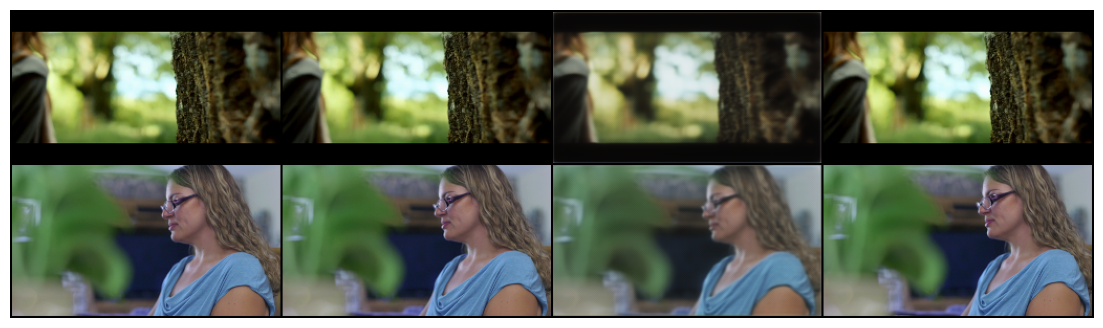

[ 1000/25000] (eta: 02:21:09) loss=2.9828 psnr=0.4482

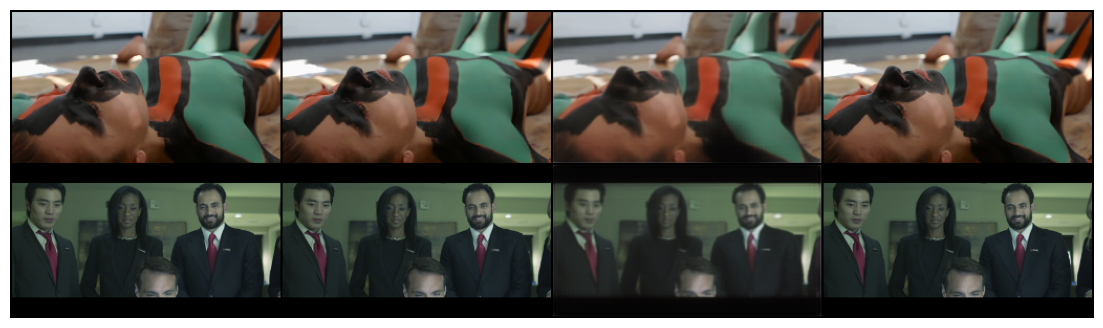

[ 1420/25000] (eta: 02:17:12) loss=2.8194 psnr=0.4312

In [ ]:
history = fit(
    model = fbnet, 
    train = train_dataloader,
    valid = valid_dataloader,
    optimizer = optim.NAdam(fbnet.parameters(), lr=1e-4), 
    loss = loss, 
    metrics = [psnr],
    epochs = epochs, 
    batch = batch, 
    save_freq = 500,
    log_freq = 1,
    log_perf_freq = 500,
    mode = "best"
)

In [ ]:
torch.save(fbnet.state_dict(), f'../models/model_v6/fbnet_e={epochs}_t={int(time.time())}.pth')    

#### Evaluate the model

In [19]:
def norm_0_1(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_history(history, norm=norm_0_1, figsize=(10,5)):
    plt.clf()
    plt.figure(figsize=figsize)
    
    metrics = list(history.keys())
    metrics = [metric for metric in metrics if "val" not in metric]
    
    data = [(index, history[metric], history['val_'+metric], metric) for index, metric in enumerate(metrics)]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    epochs = range(1, len(data[0][1]) + 1)
    
    for index, value, val_value, metric in data:
        if norm is not None:
            buffer = norm(value + val_value)
            value = buffer[0:len(epochs)]
            val_value = buffer[len(epochs):]
        
        plt.plot(epochs, value, colors[index], label=f"train {metric}")
        plt.plot(epochs, val_value, colors[index]+'--', label=f"valid {metric}")
        
    plt.xticks(epochs)    
    plt.yticks()
    plt.title("Comparision of training and validating scores")
    plt.xlabel('Epochs')
    plt.ylabel("Values" if norm is None else "Values normalized")
    plt.legend(loc='upper right')
    plt.show()

In [20]:
def evaluate(model, data, loss, metrics):
    loss_metrics = {loss.__name__: []} | {metric.__name__: [] for metric in metrics}
    model.train(False)
    for step, record in enumerate(data):
        left, right, y = record[0][0].to(device), record[0][1].to(device), record[1].to(device)

        # forward pass
        y_pred = model(left, right).detach()

        # save the loss and metrics
        loss_metrics[loss.__name__].append(loss(y, y_pred).item())
        for metric, value in zip(metrics, [metric(y, y_pred) for metric in metrics]):
            loss_metrics[metric.__name__].append(value.item())
            
        print('\rProgress [%4d/%4d]' % ((step+1), len(data)), end='')
        
    print()
            
    return {k: np.mean(v) for k, v in loss_metrics.items()}

<Figure size 640x480 with 0 Axes>

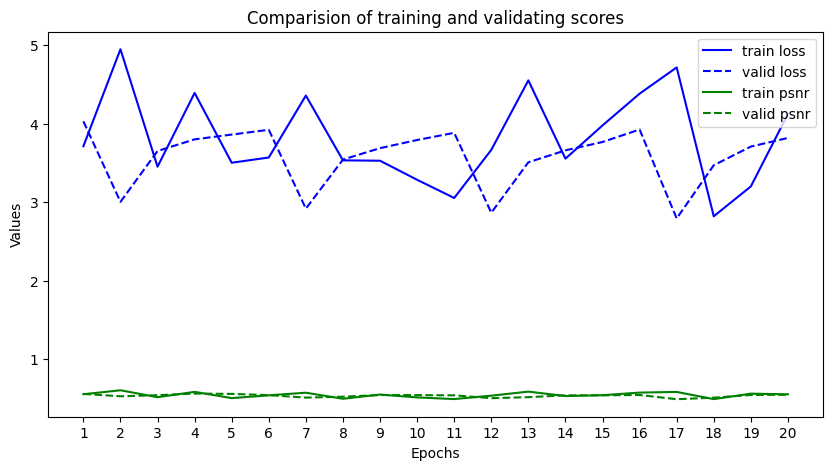

In [21]:
plot_history(history, norm=None)

<Figure size 640x480 with 0 Axes>

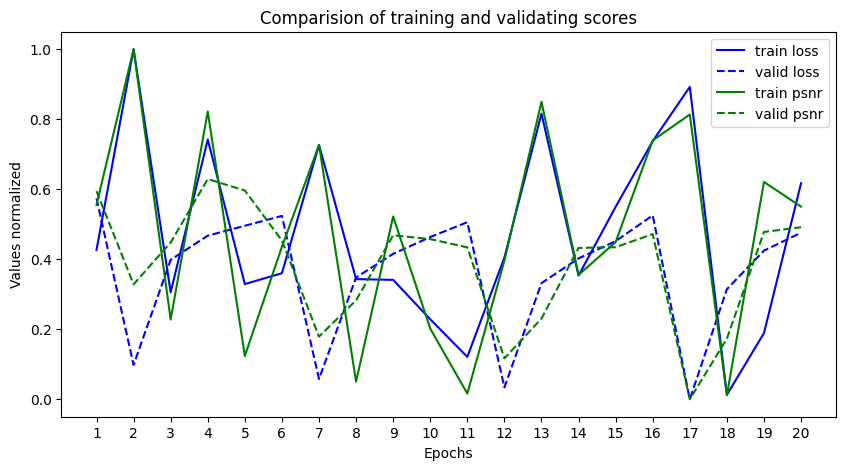

In [22]:
plot_history(history)

In [ ]:
results = evaluate(fbnet, test_dataloader, loss, [mae, mse, psnr])
for k, v in results.items():
    print('%s: %.6f' % (k, v))

#### Visualize net output

In [ ]:
def visualise_output(model, dataloader, batches = [0, 1, 2, 3, 4], figsize='auto'):
    assert len(dataloader) >= len(batches), "There is no enough data to visualise the output"
    assert dataloader.batch_size == 1, "Dataloader batch size has to be set to 1"

    if figsize == 'auto':
        figsize = (20, 10*len(batches))
    
    data = None
    loaded = 0
    model.train(False)
    for step, batch in enumerate(dataloader):
        if step in batches:
            left, right, y = batch[0][0].to(device), batch[0][1].to(device), batch[1].to(device)
            y_pred = model(left, right)
            cat_list = [
                left,
                y,
                y_pred,
                right
            ]
            if data is not None:
                cat_list = [data] + cat_list
            data = torch.cat(cat_list, dim=0)
            loaded += 1
            
            if loaded == len(batches):
                break
                
    if data is not None:
        plt.figure(figsize=figsize)
        grid = torchvision.utils.make_grid(data, nrow=4)
        plt.imshow(torch.permute(grid, (1, 2, 0)).cpu())
        plt.axis('off')
        plt.show()

In [ ]:
visualise_output(fbnet, vis_dataloader, batches=[1, 3, 4, 5, 7, 11])

#### Visualize conv2d filters

#### Visualize inner optical flow 

#### Load the model

In [ ]:
fbnet.load_state_dict(torch.load('../models/model_v6/fbnet.pth'))    